In [4]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image
import cv2
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_score, davies_bouldin_score, calinski_harabasz_score
from sklearn.manifold import TSNE
from sklearn.neighbors import NearestNeighbors
import warnings
warnings.filterwarnings('ignore')

In [5]:
# Dataset configuration
dataset_path = "/Users/muhammadhassan/Documents/Personal Publications /Education /Heriot-Watt/4th Year UG /1st Sem/F21DL DMML/Group CW/Datasets /Plant Datasets/Image Datasets /PreProcessing/Unprocessed-Image_Dataset"

# Clustering parameters
SAMPLE_SIZE_PER_CLASS = 100  # Number of images to sample per class
FEATURE_TYPE = 'combined'     # Options: 'color', 'texture', 'shape', 'combined'
RANDOM_STATE = 42             # For reproducibility

# Valid image extensions
valid_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tiff')

print("Configuration set")
print(f"Dataset path: {dataset_path}")
print(f"Sample size per class: {SAMPLE_SIZE_PER_CLASS}")
print(f"Feature type: {FEATURE_TYPE}")

Configuration set
Dataset path: /Users/muhammadhassan/Documents/Personal Publications /Education /Heriot-Watt/4th Year UG /1st Sem/F21DL DMML/Group CW/Datasets /Plant Datasets/Image Datasets /PreProcessing/Unprocessed-Image_Dataset
Sample size per class: 100
Feature type: combined


In [6]:
def extract_color_features(img_path):
    "Extract color histogram features from an image."
    "Return normalized RGB histograms."

    try:
        # Read image
        img = cv2.imread(img_path)
        if img is None:
            return None
        
        # Resize to standard size
        img = cv2.resize(img, (224, 224))
        
        # Extract color histograms for each channel (BGR)
        features = []
        for i in range(3):
            hist = cv2.calcHist([img], [i], None, [32], [0, 256])
            hist = hist.flatten()
            hist = hist / hist.sum()  # Normalize
            features.extend(hist)
        
        return np.array(features)
    
    except Exception as e:
        print(f"Error extracting color features from {img_path}: {e}")
        return None

def extract_texture_features(img_path):
    
    "Extract texture-based statistical features. Return mean, std, median, percentiles for each channel, plus edge features."
    try:
        # Read and resize image
        img = cv2.imread(img_path)
        if img is None:
            return None
        
        img = cv2.resize(img, (224, 224))
        
        features = []
        
        # Convert to grayscale for edge detection
        gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
        
        # Extract statistical features for each RGB channel
        for i in range(3):
            channel = img[:, :, i]
            features.extend([
                np.mean(channel),
                np.std(channel),
                np.median(channel),
                np.percentile(channel, 25),
                np.percentile(channel, 75)
            ])
        
        # Edge detection features using Canny
        edges = cv2.Canny(gray, 100, 200)
        features.extend([
            np.mean(edges),
            np.std(edges),
            np.sum(edges > 0) / edges.size  # Edge density
        ])
        
        return np.array(features)
    
    except Exception as e:
        print(f"Error extracting texture features from {img_path}: {e}")
        return None

def extract_combined_features(img_path):
    
    "Extract and combine both color and texture features to provide a more comprehensive representation of the image."
    
    color_feat = extract_color_features(img_path)
    texture_feat = extract_texture_features(img_path)
    
    if color_feat is None or texture_feat is None:
        return None
    
    # Concatenate features
    combined = np.concatenate([color_feat, texture_feat])
    return combined

print("Feature extraction functions defined")

Feature extraction functions defined


In [7]:
print("Loading Dataset and Extracting Features")


# Get class names (folders)
class_names = [d for d in os.listdir(dataset_path) 
               if os.path.isdir(os.path.join(dataset_path, d)) and not d.startswith('.')]
class_names.sort()

print(f"\nNumber of classes found: {len(class_names)}")
print("Classes:", class_names[:5], "..." if len(class_names) > 5 else "")

# Initialize storage
all_features = []
all_labels = []
all_paths = []

# Extract features from each class
print(f"\nExtracting features from {SAMPLE_SIZE_PER_CLASS} images per class...")

for class_idx, class_name in enumerate(class_names):
    print(f"\nClass {class_idx + 1}/{len(class_names)}: {class_name}")
    
    # Get image files in this class folder
    class_path = os.path.join(dataset_path, class_name)
    image_files = [f for f in os.listdir(class_path) 
                   if f.lower().endswith(valid_extensions)]
    
    # Sample images
    sample_size = min(SAMPLE_SIZE_PER_CLASS, len(image_files))
    sampled_files = np.random.choice(image_files, sample_size, replace=False)
    
    # Extract features from sampled images
    successful = 0
    for img_file in sampled_files:
        img_path = os.path.join(class_path, img_file)
        
        # Extract features
        if FEATURE_TYPE == 'color':
            features = extract_color_features(img_path)
        elif FEATURE_TYPE == 'texture':
            features = extract_texture_features(img_path)
        else:  # combined
            features = extract_combined_features(img_path)
        
        if features is not None:
            all_features.append(features)
            all_labels.append(class_name)
            all_paths.append(img_path)
            successful += 1
    
    print(f"Successfully extracted features from {successful}/{sample_size} images")

# Convert to numpy arrays
X = np.array(all_features)
y = np.array(all_labels)

print(f"\n{'='*60}")
print("Feature extraction completed")
print(f"Total samples: {X.shape[0]}")
print(f"Feature dimensions: {X.shape[1]}")
print(f"{'='*60}")


Loading Dataset and Extracting Features

Number of classes found: 7
Classes: ['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight'] ...

Extracting features from 100 images per class...

Class 1/7: Potato___Early_blight
Successfully extracted features from 100/100 images

Class 2/7: Potato___Late_blight
Successfully extracted features from 100/100 images

Class 3/7: Potato___healthy
Successfully extracted features from 100/100 images

Class 4/7: Tomato_Bacterial_spot
Successfully extracted features from 100/100 images

Class 5/7: Tomato_Early_blight
Successfully extracted features from 100/100 images

Class 6/7: Tomato_Late_blight
Successfully extracted features from 100/100 images

Class 7/7: Tomato_healthy
Successfully extracted features from 100/100 images

Feature extraction completed
Total samples: 700
Feature dimensions: 114


In [8]:
print("Feature PreProcessing and Standardization")


# Standardize features (zero mean, unit variance)
# This is important for clustering algorithms
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

print("Features standardized (mean=0, std=1)")
print(f"Mean after scaling: {np.mean(X_scaled, axis=0)[:5]}")
print(f"Std after scaling: {np.std(X_scaled, axis=0)[:5]}")

Feature PreProcessing and Standardization
Features standardized (mean=0, std=1)
Mean after scaling: [ 1.26882631e-17 -7.15300834e-17 -2.93416085e-17 -9.48447670e-17
  6.78822078e-17]
Std after scaling: [1. 1. 1. 1. 1.]


PCA
Original dimensions: 114
Reduced dimensions: 50
Explained variance: 97.96%


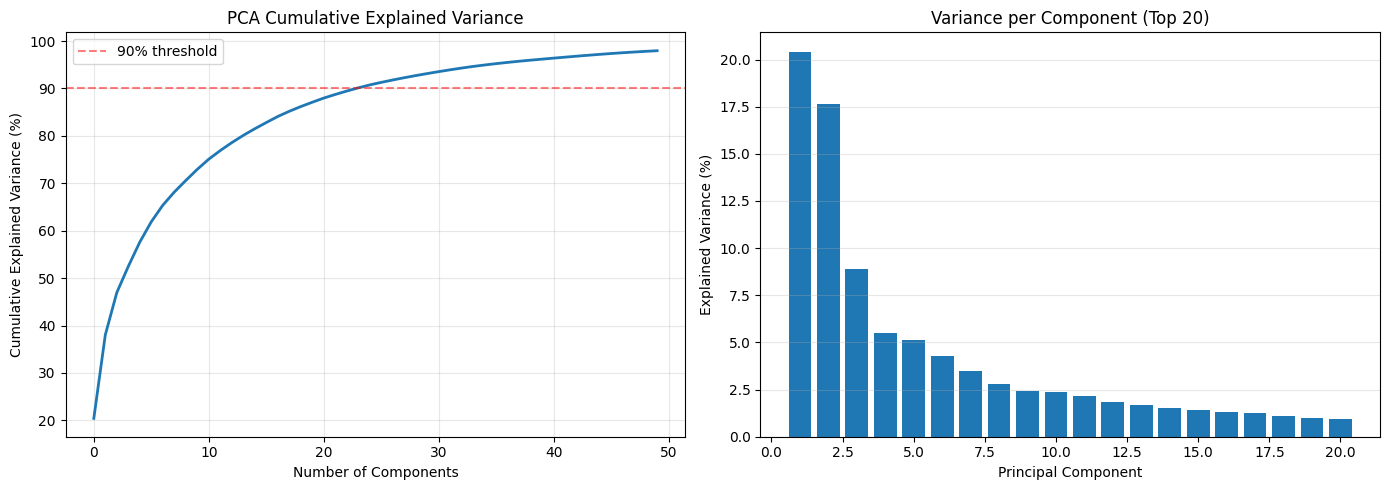

In [9]:
print("PCA")


# Apply PCA to reduce dimensions
n_components = min(50, X_scaled.shape[1])
pca = PCA(n_components=n_components, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)

# Calculate explained variance
explained_variance = np.sum(pca.explained_variance_ratio_) * 100

print(f"Original dimensions: {X_scaled.shape[1]}")
print(f"Reduced dimensions: {n_components}")
print(f"Explained variance: {explained_variance:.2f}%")

# Visualize explained variance
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# Cumulative explained variance
ax1.plot(np.cumsum(pca.explained_variance_ratio_) * 100, linewidth=2)
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('Cumulative Explained Variance (%)')
ax1.set_title('PCA Cumulative Explained Variance')
ax1.grid(True, alpha=0.3)
ax1.axhline(y=90, color='r', linestyle='--', alpha=0.5, label='90% threshold')
ax1.legend()

# Individual component variance
n_show = min(20, len(pca.explained_variance_ratio_))
ax2.bar(range(1, n_show + 1), pca.explained_variance_ratio_[:n_show] * 100)
ax2.set_xlabel('Principal Component')
ax2.set_ylabel('Explained Variance (%)')
ax2.set_title(f'Variance per Component (Top {n_show})')
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

finding optimal clusters

Testing different values of k for K-Means...
k=2: Silhouette=0.163, Davies-Bouldin=2.124
k=3: Silhouette=0.149, Davies-Bouldin=1.953
k=4: Silhouette=0.168, Davies-Bouldin=1.804
k=5: Silhouette=0.130, Davies-Bouldin=1.856
k=6: Silhouette=0.146, Davies-Bouldin=1.672
k=7: Silhouette=0.134, Davies-Bouldin=1.692
k=8: Silhouette=0.129, Davies-Bouldin=1.715
k=9: Silhouette=0.141, Davies-Bouldin=1.722
k=10: Silhouette=0.150, Davies-Bouldin=1.641
k=11: Silhouette=0.124, Davies-Bouldin=1.649
k=12: Silhouette=0.131, Davies-Bouldin=1.715
k=13: Silhouette=0.135, Davies-Bouldin=1.716
k=14: Silhouette=0.123, Davies-Bouldin=1.706
k=15: Silhouette=0.118, Davies-Bouldin=1.587


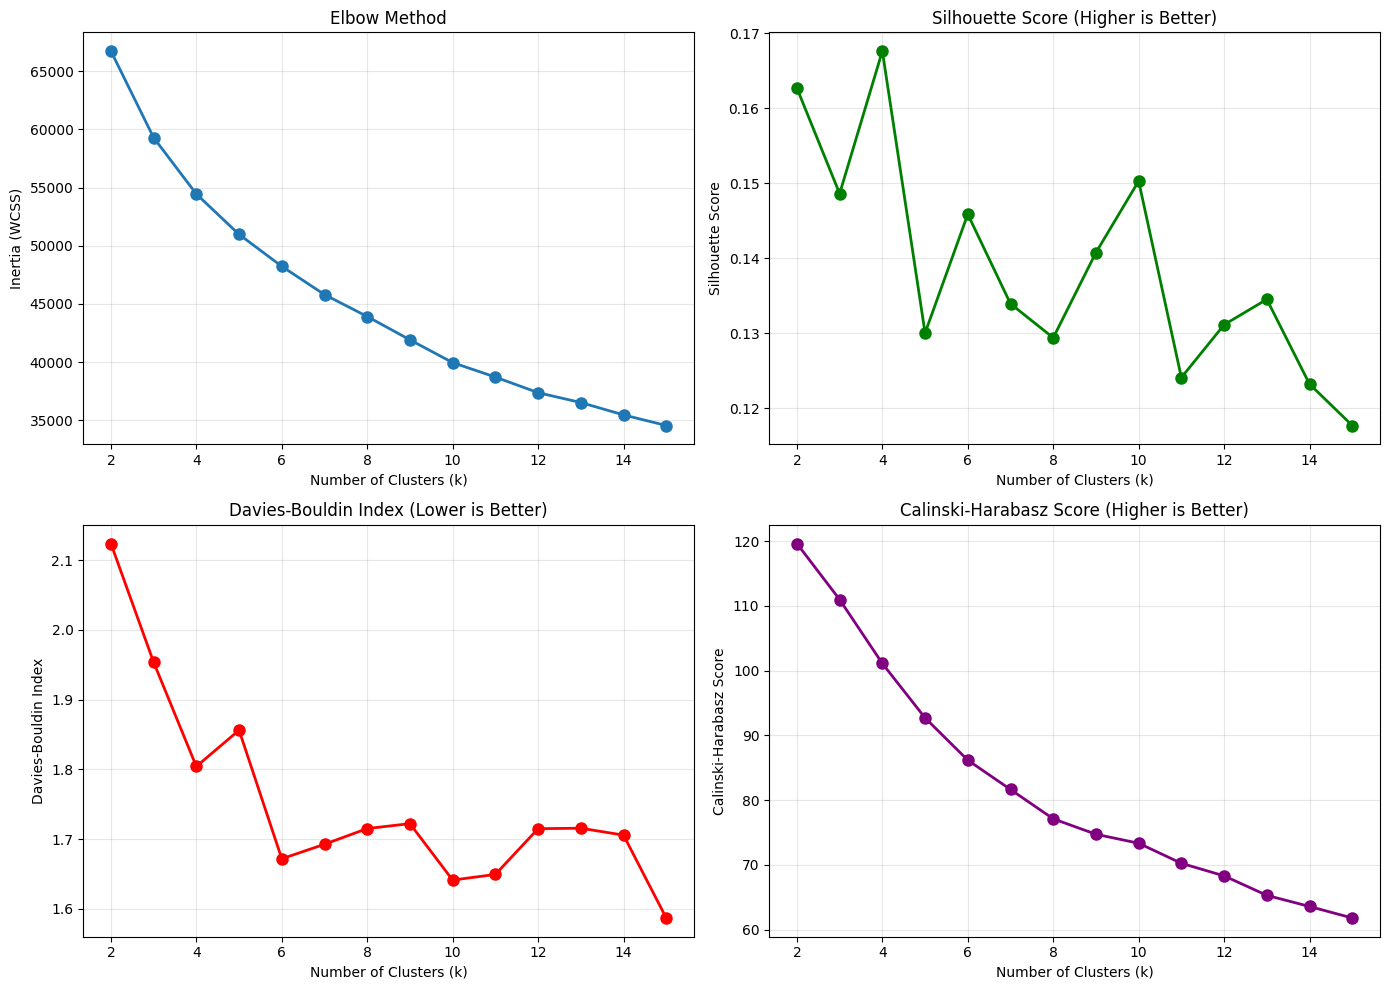


Optimal k based on different metrics:
  Silhouette Score: k = 4
  Davies-Bouldin Index: k = 15
  Calinski-Harabasz Score: k = 2

Selected optimal k = 4


In [10]:
print("finding optimal clusters")


# Test different cluster numbers
k_range = range(2, 16)
inertias = []
silhouette_scores = []
davies_bouldin_scores = []
calinski_scores = []

print("\nTesting different values of k for K-Means...")

for k in k_range:
    # Fit K-Means
    kmeans = KMeans(n_clusters=k, random_state=RANDOM_STATE, n_init=10)
    cluster_labels = kmeans.fit_predict(X_pca)
    
    # Calculate evaluation metrics
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_pca, cluster_labels))
    davies_bouldin_scores.append(davies_bouldin_score(X_pca, cluster_labels))
    calinski_scores.append(calinski_harabasz_score(X_pca, cluster_labels))
    
    print(f"k={k}: Silhouette={silhouette_scores[-1]:.3f}, "
          f"Davies-Bouldin={davies_bouldin_scores[-1]:.3f}")

# Plot evaluation metrics
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Elbow plot (Within-cluster sum of squares)
axes[0, 0].plot(k_range, inertias, 'o-', linewidth=2, markersize=8)
axes[0, 0].set_xlabel('Number of Clusters (k)')
axes[0, 0].set_ylabel('Inertia (WCSS)')
axes[0, 0].set_title('Elbow Method')
axes[0, 0].grid(True, alpha=0.3)

# Silhouette score (higher is better)
axes[0, 1].plot(k_range, silhouette_scores, 'o-', linewidth=2, markersize=8, color='green')
axes[0, 1].set_xlabel('Number of Clusters (k)')
axes[0, 1].set_ylabel('Silhouette Score')
axes[0, 1].set_title('Silhouette Score (Higher is Better)')
axes[0, 1].grid(True, alpha=0.3)

# Davies-Bouldin index (lower is better)
axes[1, 0].plot(k_range, davies_bouldin_scores, 'o-', linewidth=2, markersize=8, color='red')
axes[1, 0].set_xlabel('Number of Clusters (k)')
axes[1, 0].set_ylabel('Davies-Bouldin Index')
axes[1, 0].set_title('Davies-Bouldin Index (Lower is Better)')
axes[1, 0].grid(True, alpha=0.3)

# Calinski-Harabasz score (higher is better)
axes[1, 1].plot(k_range, calinski_scores, 'o-', linewidth=2, markersize=8, color='purple')
axes[1, 1].set_xlabel('Number of Clusters (k)')
axes[1, 1].set_ylabel('Calinski-Harabasz Score')
axes[1, 1].set_title('Calinski-Harabasz Score (Higher is Better)')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Determine optimal k based on metrics
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
optimal_k_davies = k_range[np.argmin(davies_bouldin_scores)]
optimal_k_calinski = k_range[np.argmax(calinski_scores)]

print(f"\nOptimal k based on different metrics:")
print(f"  Silhouette Score: k = {optimal_k_silhouette}")
print(f"  Davies-Bouldin Index: k = {optimal_k_davies}")
print(f"  Calinski-Harabasz Score: k = {optimal_k_calinski}")

# Use silhouette score recommendation
optimal_k = optimal_k_silhouette
print(f"\nSelected optimal k = {optimal_k}")

In [11]:
# Apply K-Means with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=RANDOM_STATE, n_init=10)
kmeans_labels = kmeans.fit_predict(X_pca)

print(f"K-Means clustering completed with k={optimal_k}")
print(f"Cluster distribution:")

# Count samples in each cluster
unique, counts = np.unique(kmeans_labels, return_counts=True)
for cluster_id, count in zip(unique, counts):
    print(f"  Cluster {cluster_id}: {count} samples ({count/len(kmeans_labels)*100:.1f}%)")

K-Means clustering completed with k=4
Cluster distribution:
  Cluster 0: 286 samples (40.9%)
  Cluster 1: 191 samples (27.3%)
  Cluster 2: 35 samples (5.0%)
  Cluster 3: 188 samples (26.9%)


In [12]:
# Apply hierarchical clustering
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
hierarchical_labels = hierarchical.fit_predict(X_pca)

print(f"Hierarchical clustering completed with k={optimal_k}")
print(f"Cluster distribution:")

# Count samples in each cluster
unique, counts = np.unique(hierarchical_labels, return_counts=True)
for cluster_id, count in zip(unique, counts):
    print(f"  Cluster {cluster_id}: {count} samples ({count/len(hierarchical_labels)*100:.1f}%)")

Hierarchical clustering completed with k=4
Cluster distribution:
  Cluster 0: 296 samples (42.3%)
  Cluster 1: 276 samples (39.4%)
  Cluster 2: 88 samples (12.6%)
  Cluster 3: 40 samples (5.7%)


In [13]:
# Estimate eps parameter using k-nearest neighbors
neighbors = NearestNeighbors(n_neighbors=5)
neighbors_fit = neighbors.fit(X_pca)
distances, indices = neighbors_fit.kneighbors(X_pca)

# Sort distances and use 90th percentile as eps
sorted_distances = np.sort(distances[:, -1], axis=0)
eps = np.percentile(sorted_distances, 90)

print(f"Estimated eps parameter: {eps:.3f}")

# Apply DBSCAN
dbscan = DBSCAN(eps=eps, min_samples=5)
dbscan_labels = dbscan.fit_predict(X_pca)

# Count clusters and noise points
n_clusters_dbscan = len(set(dbscan_labels)) - (1 if -1 in dbscan_labels else 0)
n_noise = list(dbscan_labels).count(-1)

print(f"DBSCAN clustering completed")
print(f"Number of clusters found: {n_clusters_dbscan}")
print(f"Number of noise points: {n_noise} ({n_noise/len(dbscan_labels)*100:.1f}%)")

Estimated eps parameter: 9.817
DBSCAN clustering completed
Number of clusters found: 1
Number of noise points: 59 (8.4%)


clustering evaluation

K-Means Performance:
  Silhouette Score: 0.1676
  Davies-Bouldin Index: 1.8041
  Calinski-Harabasz Score: 101.11

Hierarchical Performance:
  Silhouette Score: 0.1546
  Davies-Bouldin Index: 1.9392
  Calinski-Harabasz Score: 86.38
Performance comparison table
   Algorithm  Clusters  Silhouette Score  Davies-Bouldin Index  Calinski-Harabasz Score
     K-Means         4          0.167600              1.804051               101.114725
Hierarchical         4          0.154616              1.939223                86.377496


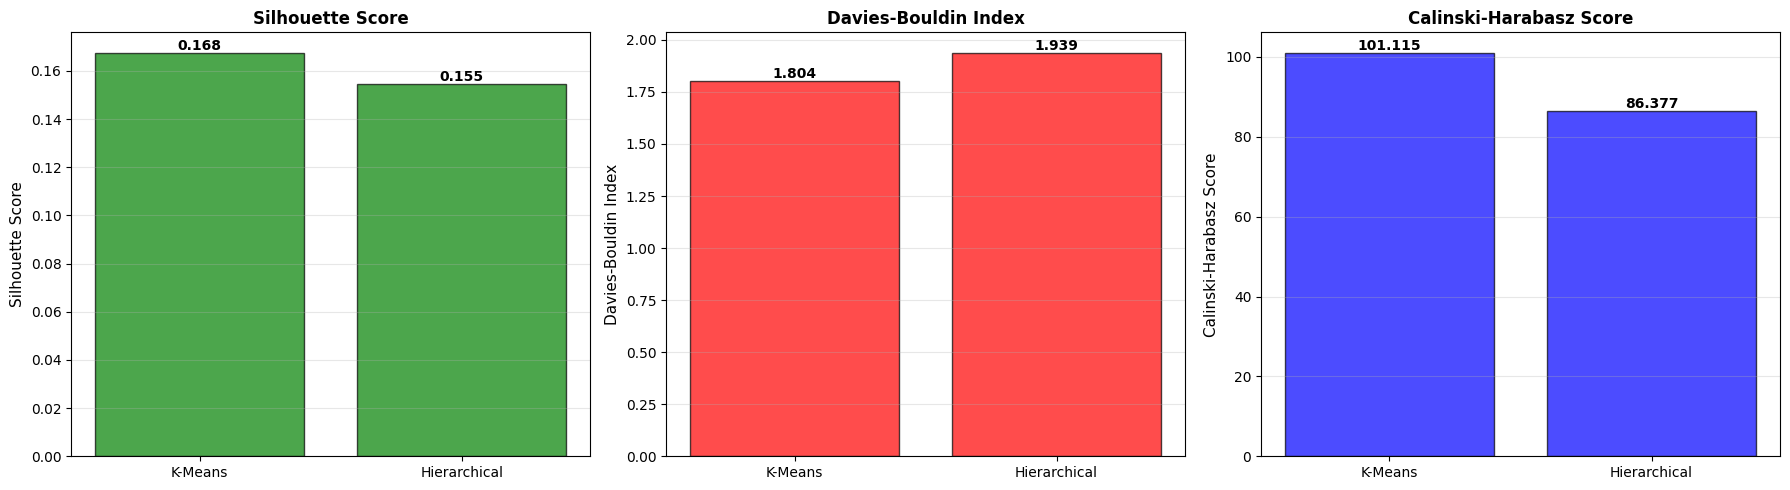

In [14]:
print("clustering evaluation")


# Initialize results storage
evaluation_results = []

# Evaluate K-Means
kmeans_silhouette = silhouette_score(X_pca, kmeans_labels)
kmeans_davies = davies_bouldin_score(X_pca, kmeans_labels)
kmeans_calinski = calinski_harabasz_score(X_pca, kmeans_labels)

evaluation_results.append({
    'Algorithm': 'K-Means',
    'Clusters': optimal_k,
    'Silhouette Score': kmeans_silhouette,
    'Davies-Bouldin Index': kmeans_davies,
    'Calinski-Harabasz Score': kmeans_calinski
})

print(f"\nK-Means Performance:")
print(f"  Silhouette Score: {kmeans_silhouette:.4f}")
print(f"  Davies-Bouldin Index: {kmeans_davies:.4f}")
print(f"  Calinski-Harabasz Score: {kmeans_calinski:.2f}")

# Evaluate Hierarchical
hier_silhouette = silhouette_score(X_pca, hierarchical_labels)
hier_davies = davies_bouldin_score(X_pca, hierarchical_labels)
hier_calinski = calinski_harabasz_score(X_pca, hierarchical_labels)

evaluation_results.append({
    'Algorithm': 'Hierarchical',
    'Clusters': optimal_k,
    'Silhouette Score': hier_silhouette,
    'Davies-Bouldin Index': hier_davies,
    'Calinski-Harabasz Score': hier_calinski
})

print(f"\nHierarchical Performance:")
print(f"  Silhouette Score: {hier_silhouette:.4f}")
print(f"  Davies-Bouldin Index: {hier_davies:.4f}")
print(f"  Calinski-Harabasz Score: {hier_calinski:.2f}")

# Evaluate DBSCAN (only if valid clusters exist)
if n_clusters_dbscan > 1 and n_noise < len(dbscan_labels) * 0.5:
    valid_mask = dbscan_labels != -1
    
    if np.sum(valid_mask) > 0:
        dbscan_silhouette = silhouette_score(X_pca[valid_mask], dbscan_labels[valid_mask])
        dbscan_davies = davies_bouldin_score(X_pca[valid_mask], dbscan_labels[valid_mask])
        dbscan_calinski = calinski_harabasz_score(X_pca[valid_mask], dbscan_labels[valid_mask])
        
        evaluation_results.append({
            'Algorithm': 'DBSCAN',
            'Clusters': n_clusters_dbscan,
            'Silhouette Score': dbscan_silhouette,
            'Davies-Bouldin Index': dbscan_davies,
            'Calinski-Harabasz Score': dbscan_calinski
        })
        
        print(f"\nDBSCAN Performance:")
        print(f"  Silhouette Score: {dbscan_silhouette:.4f}")
        print(f"  Davies-Bouldin Index: {dbscan_davies:.4f}")
        print(f"  Calinski-Harabasz Score: {dbscan_calinski:.2f}")

# Create evaluation dataframe
eval_df = pd.DataFrame(evaluation_results)


print("Performance comparison table")

print(eval_df.to_string(index=False))

# Visualize comparison
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

metrics = ['Silhouette Score', 'Davies-Bouldin Index', 'Calinski-Harabasz Score']
colors = ['green', 'red', 'blue']

for idx, metric in enumerate(metrics):
    ax = axes[idx]
    values = eval_df[metric].values
    algorithms = eval_df['Algorithm'].values
    
    bars = ax.bar(algorithms, values, color=colors[idx], alpha=0.7, edgecolor='black')
    ax.set_ylabel(metric, fontsize=11)
    ax.set_title(metric, fontsize=12, fontweight='bold')
    ax.grid(True, alpha=0.3, axis='y')
    
    # Add value labels
    for bar in bars:
        height = bar.get_height()
        ax.text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontweight='bold')

plt.tight_layout()
plt.show()


CLUSTER VISUALIZATION USING t-SNE
t-SNE completed


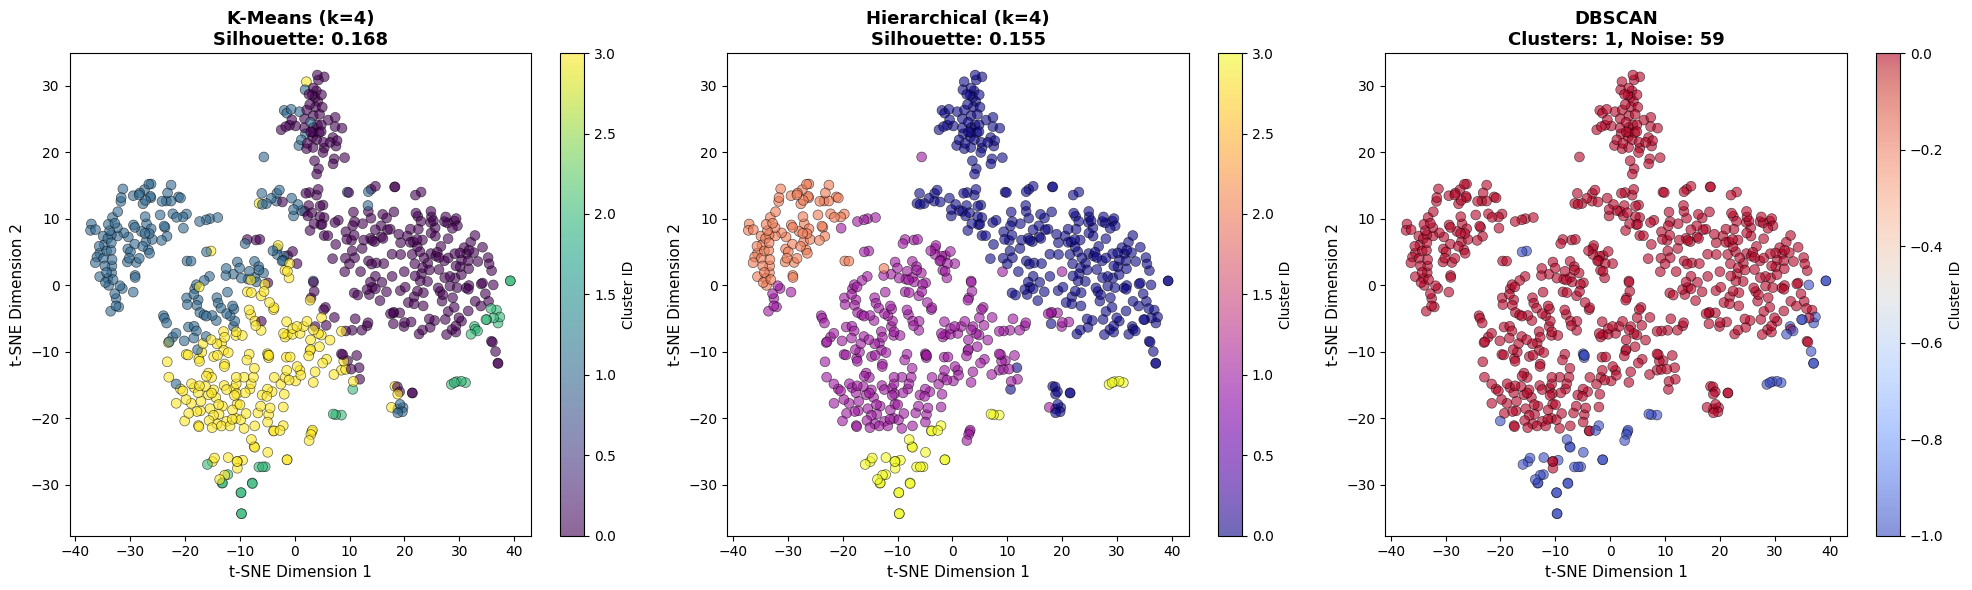

In [15]:
print("\n" + "="*60)
print("CLUSTER VISUALIZATION USING t-SNE")
print("="*60)

# Apply t-SNE for 2D visualization
tsne = TSNE(n_components=2, random_state=RANDOM_STATE, perplexity=30, max_iter=1000)
X_tsne = tsne.fit_transform(X_pca)
print("t-SNE completed")

# Create visualization for all clustering algorithms
fig, axes = plt.subplots(1, 3, figsize=(20, 6))

# K-Means visualization
scatter1 = axes[0].scatter(X_tsne[:, 0], X_tsne[:, 1], 
                          c=kmeans_labels, cmap='viridis', 
                          alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[0].set_title(f'K-Means (k={optimal_k})\nSilhouette: {kmeans_silhouette:.3f}', 
                 fontweight='bold', fontsize=13)
axes[0].set_xlabel('t-SNE Dimension 1', fontsize=11)
axes[0].set_ylabel('t-SNE Dimension 2', fontsize=11)
plt.colorbar(scatter1, ax=axes[0], label='Cluster ID')

# Hierarchical visualization
scatter2 = axes[1].scatter(X_tsne[:, 0], X_tsne[:, 1], 
                          c=hierarchical_labels, cmap='plasma', 
                          alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[1].set_title(f'Hierarchical (k={optimal_k})\nSilhouette: {hier_silhouette:.3f}', 
                 fontweight='bold', fontsize=13)
axes[1].set_xlabel('t-SNE Dimension 1', fontsize=11)
axes[1].set_ylabel('t-SNE Dimension 2', fontsize=11)
plt.colorbar(scatter2, ax=axes[1], label='Cluster ID')

# DBSCAN visualization
scatter3 = axes[2].scatter(X_tsne[:, 0], X_tsne[:, 1], 
                          c=dbscan_labels, cmap='coolwarm', 
                          alpha=0.6, s=50, edgecolors='black', linewidth=0.5)
axes[2].set_title(f'DBSCAN\nClusters: {n_clusters_dbscan}, Noise: {n_noise}', 
                 fontweight='bold', fontsize=13)
axes[2].set_xlabel('t-SNE Dimension 1', fontsize=11)
axes[2].set_ylabel('t-SNE Dimension 2', fontsize=11)
plt.colorbar(scatter3, ax=axes[2], label='Cluster ID')

plt.tight_layout()
plt.show()


K-Means Cluster Sizes:
  Cluster 0: 286 images (40.9%)
  Cluster 1: 191 images (27.3%)
  Cluster 2: 35 images (5.0%)
  Cluster 3: 188 images (26.9%)

Class Distribution within K-Means Clusters:

Cluster 0 (n=286):
  Top classes:
    1. Potato___Early_blight: 95 (33.2%)
    2. Tomato_healthy: 48 (16.8%)
    3. Potato___Late_blight: 43 (15.0%)

Cluster 1 (n=191):
  Top classes:
    1. Tomato_healthy: 51 (26.7%)
    2. Potato___Late_blight: 39 (20.4%)
    3. Tomato_Late_blight: 37 (19.4%)

Cluster 2 (n=35):
  Top classes:
    1. Potato___healthy: 26 (74.3%)
    2. Tomato_Late_blight: 5 (14.3%)
    3. Tomato_Early_blight: 3 (8.6%)

Cluster 3 (n=188):
  Top classes:
    1. Tomato_Bacterial_spot: 64 (34.0%)
    2. Tomato_Early_blight: 53 (28.2%)
    3. Potato___healthy: 34 (18.1%)

Generating cluster-class distribution heatmap...


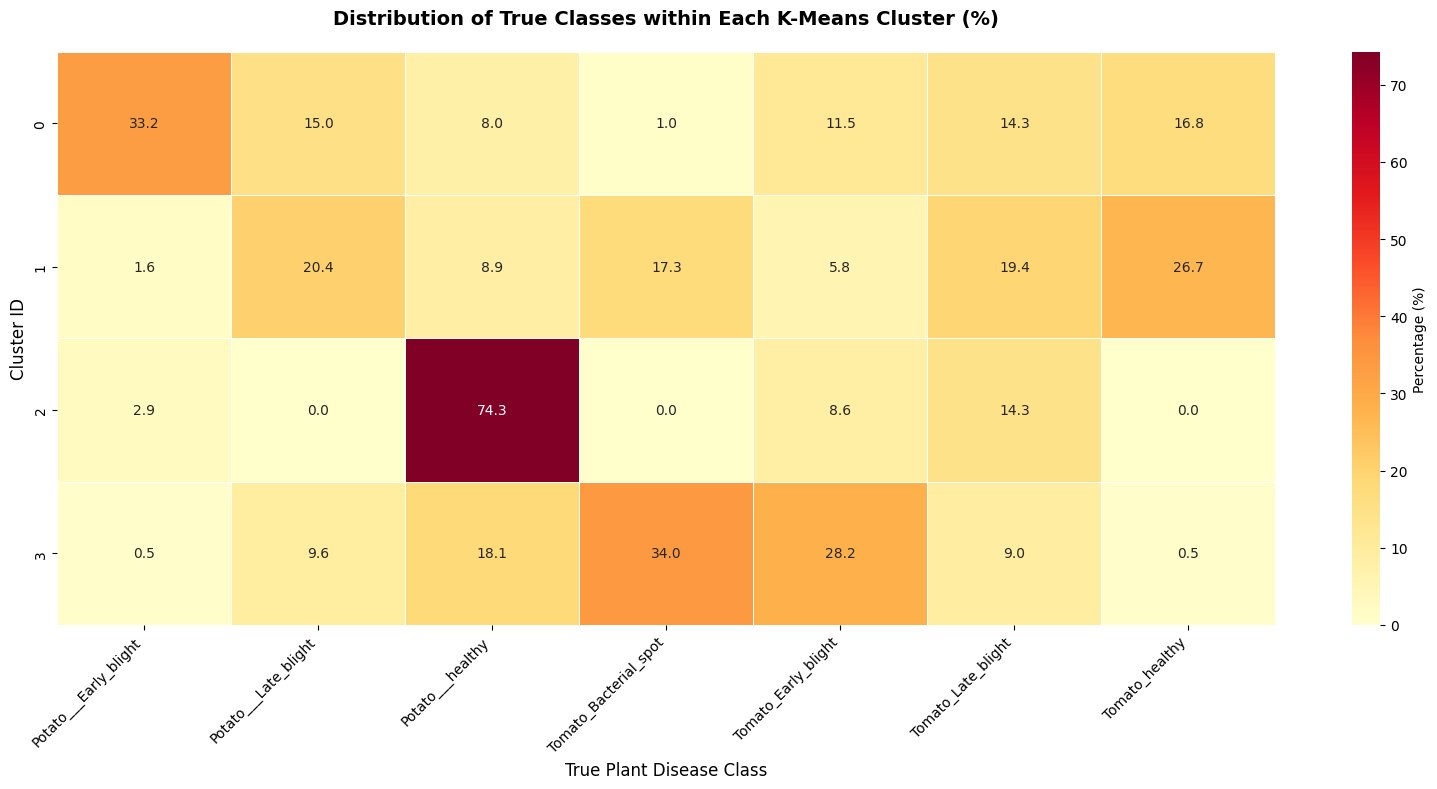

In [16]:
# Create results dataframe
results_df = pd.DataFrame({
    'Image_Path': all_paths,
    'True_Class': y,
    'KMeans_Cluster': kmeans_labels,
    'Hierarchical_Cluster': hierarchical_labels,
    'DBSCAN_Cluster': dbscan_labels
})

# Analyze K-Means clusters
print("\nK-Means Cluster Sizes:")
cluster_counts = pd.Series(kmeans_labels).value_counts().sort_index()
for cluster_id, count in cluster_counts.items():
    print(f"  Cluster {cluster_id}: {count} images ({count/len(kmeans_labels)*100:.1f}%)")

print("\nClass Distribution within K-Means Clusters:")
for cluster_id in range(optimal_k):
    cluster_mask = results_df['KMeans_Cluster'] == cluster_id
    cluster_classes = results_df[cluster_mask]['True_Class'].value_counts()
    
    print(f"\nCluster {cluster_id} (n={cluster_counts[cluster_id]}):")
    print(f"  Top classes:")
    for i, (class_name, count) in enumerate(cluster_classes.head(3).items()):
        percentage = count / cluster_counts[cluster_id] * 100
        print(f"    {i+1}. {class_name}: {count} ({percentage:.1f}%)")

# Create cross-tabulation heatmap
print("\nGenerating cluster-class distribution heatmap...")
cluster_class_matrix = pd.crosstab(results_df['KMeans_Cluster'], 
                                   results_df['True_Class'], 
                                   normalize='index') * 100

plt.figure(figsize=(16, 8))
sns.heatmap(cluster_class_matrix, annot=True, fmt='.1f', cmap='YlOrRd', 
            cbar_kws={'label': 'Percentage (%)'}, linewidths=0.5)
plt.title('Distribution of True Classes within Each K-Means Cluster (%)', 
          fontweight='bold', fontsize=14, pad=20)
plt.xlabel('True Plant Disease Class', fontsize=12)
plt.ylabel('Cluster ID', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [17]:
print("\nDATASET SUMMARY:")
print(f"  Total images analyzed: {X.shape[0]:,}")
print(f"  Number of classes: {len(class_names)}")
print(f"  Original feature dimensions: {X.shape[1]}")
print(f"  Reduced dimensions (PCA): {n_components}")
print(f"  Explained variance (PCA): {explained_variance:.2f}%")

print("\nCLUSTERING CONFIGURATION:")
print(f"  Feature type: {FEATURE_TYPE}")
print(f"  Optimal number of clusters (k): {optimal_k}")
print(f"  Clustering algorithms applied: K-Means, Hierarchical, DBSCAN")

print("\nPERFORMACE METRICS:")
print("  " + "-"*67)
print(f"  {'Algorithm':<15} {'Silhouette':>12} {'Davies-Bouldin':>16} {'Calinski-Harabasz':>20}")
print("  " + "-"*67)
for _, row in eval_df.iterrows():
    print(f"  {row['Algorithm']:<15} {row['Silhouette Score']:>12.4f} "
          f"{row['Davies-Bouldin Index']:>16.4f} {row['Calinski-Harabasz Score']:>20.2f}")
print("  " + "-"*67)

# Determine best algorithm
best_idx = eval_df['Silhouette Score'].idxmax()
best_algorithm = eval_df.loc[best_idx, 'Algorithm']
best_silhouette = eval_df.loc[best_idx, 'Silhouette Score']

print(f"\nBEST PERFORMING ALGORITHM:")
print(f"  {best_algorithm} with Silhouette Score: {best_silhouette:.4f}")

print("\nKEY FINDINGS:")
print(f"  - Images naturally group into {optimal_k} distinct clusters")
print(f"  - Clusters show varying degrees of purity relative to true classes")
print(f"  - {FEATURE_TYPE.capitalize()} features capture meaningful visual patterns")
print(f"  - Some disease classes exhibit visual similarity (cluster overlap)")

print("\nINTERPRETATION:")
print("  - Clustering reveals underlying patterns in plant disease images")
print("  - Mixed clusters indicate visual similarity between certain diseases")
print("  - Pure clusters suggest distinct visual characteristics")
print("  - Results validate the complexity requiring CNN models for classification")

print("\nClustering analysis completed successfully")


DATASET SUMMARY:
  Total images analyzed: 700
  Number of classes: 7
  Original feature dimensions: 114
  Reduced dimensions (PCA): 50
  Explained variance (PCA): 97.96%

CLUSTERING CONFIGURATION:
  Feature type: combined
  Optimal number of clusters (k): 4
  Clustering algorithms applied: K-Means, Hierarchical, DBSCAN

PERFORMACE METRICS:
  -------------------------------------------------------------------
  Algorithm         Silhouette   Davies-Bouldin    Calinski-Harabasz
  -------------------------------------------------------------------
  K-Means               0.1676           1.8041               101.11
  Hierarchical          0.1546           1.9392                86.38
  -------------------------------------------------------------------

BEST PERFORMING ALGORITHM:
  K-Means with Silhouette Score: 0.1676

KEY FINDINGS:
  - Images naturally group into 4 distinct clusters
  - Clusters show varying degrees of purity relative to true classes
  - Combined features capture meanin